## EPFL: CS-433 Machine Learning
### Project 1: Higgs Boson

Team: GoLinearOrGoHome (Antoine Bonnet, Melanie X, Camille X)

In this project, we train multiple models for the task of binary classification on the Higgs Boson dataset. 
We compare their respective performances and choose the model with highest accuracy. This optimal model is then used to predict unseen test data. 


### 1. Loading data

We first import required libraries and our code. 

In [2]:
import math
import numpy as np
import pandas as pd
from implementations import *
from load_data import *
from train import *
from helpers import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In these experiments, we perform 5-fold cross-validation hyperparameter tuning with grid search for every model using 200K of our 250K training set. We use the remaining 50K samples as a synthetic test set to measure the generalization capacity of each model. 

In [4]:
training_data, training_labels, training_ids, testing_data, testing_ids = load_data(sub_sample=False)
train_data = training_data[:200000]
train_labels = training_labels[:200000]
test_data = training_data[200000:]
test_labels = training_labels[200000:]
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)


(200000, 30) (200000,)
(50000, 30) (50000,)


In [5]:
!head -7 ../data/train.csv 

Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
100000,s,138.47,51.655,97.827,27.98,0.91,124.711,2.666,3.064,41.928,197.76,1.582,1.396,0.2,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.15,0.444,46.062,1.24,-2.475,113.497
100001,b,160.937,68.768,103.235,48.146,-999,-999,-999,3.473,2.078,125.157,0.879,1.414,-999,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999,-999,-999,46.226
100002,b,-999,162.172,125.953,35.635,-999,-999,-999,3.148,9.336,197.814,3.776,1.414,-999,32.154,-0.705,-2

In [6]:
!head -7 ../data/test.csv 

Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
350000,?,-999,79.589,23.916,3.036,-999,-999,-999,0.903,3.036,56.018,1.536,-1.404,-999,22.088,-0.54,-0.609,33.93,-0.504,-1.511,48.509,2.022,98.556,0,-999,-999,-999,-999,-999,-999,0
350001,?,106.398,67.49,87.949,49.994,-999,-999,-999,2.048,2.679,132.865,1.777,-1.204,-999,30.716,-1.784,3.054,54.574,-0.169,1.795,21.093,-1.138,176.251,1,47.575,-0.553,-0.849,-999,-999,-999,47.575
350002,?,117.794,56.226,96.358,4.137,-999,-999,-999,2.755,4.137,97.6,1.096,-1.408,-999,46.564,-0.298,3.079,51.036,-0.548,0

The training labels consist of either 's' or 'b' values, which respectively denote 'signal' (presence of the Higgs Boson) and 'background' (absence of the Higgs Boson). The test set contains only features and no labels. Our goal is to fill in these labels with highest accuracy. 

Some values are missing from the data, as indicated by the value -999. We look at the proportion of missing values for each column. 

In [7]:
(train_data == -999).sum(axis=0) / train_data.shape[0]

array([0.15263 , 0.      , 0.      , 0.      , 0.710245, 0.710245,
       0.710245, 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.710245, 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.39983 ,
       0.39983 , 0.39983 , 0.710245, 0.710245, 0.710245, 0.      ])

In [8]:
(test_data == -999).sum(axis=0) / test_data.shape[0]

array([0.15176, 0.     , 0.     , 0.     , 0.70816, 0.70816, 0.70816,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.70816, 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.39894, 0.39894, 0.39894, 0.70816, 0.70816,
       0.70816, 0.     ])

### 2. Pre-processing data

To train our models, we extract the training features and label, as well as the test features. Our pre-processing consists of the following procedures: 
- **Replacing missing values**: columns containing more than $\alpha$% of missing values (indicated by -999) are removed, and the remaining missing values are replaced by their respective median.
- **Removing outliers**: datapoints which contain at least one feature that is $\beta$ times standard deviations away from the mean are removed. This is only performed for the training data (and not the test data).
- **Polynomial expansion**: Each feature in the data matrix is augmented by a given degree. A column of 1's is also added for biasing. 
- **Standardization**: All columns are standardized to follow a standard normal distribution $N(0,1)$.

These operations are carried out in the `pre_process` function. We will perform hyperparameter tuning on the degree as well as the $\alpha$ and $\beta$ thresholds. 

### 3. Training Models 

We now train different models for this binary classification task. For each model, we consider different combinations of the pre-processing hyperparameter values, as well as the respective model hyperparameter values. We use 5-fold cross validation to select the hyperparameter set with the highest validation accuracy. We then obtain the optimal validation accuracy for each model. 

In [9]:
K = 5 # Number of folds for cross-validation
verbose = True # Choose if you want to print the accuracies for each hyperparameter set 

In [10]:
def testAccuracy(model_name, optPreHyp, optHyp):
    # Pre-process whole training set with optimal pre-processing hyperparameters
    x_train_opt, y_train_opt = pre_process(x=train_data, y=train_labels, **optPreHyp)

    # Train model with optimal hyperparameters and whole training set
    wOpt, _ = model_name(y=y_train_opt, tx=x_train_opt, **optHyp)

    # Pre-process whole test set but keep outlier rows
    fullOptPreHyp = optPreHyp
    fullOptPreHyp['beta'] = None
    x_opt_test, _ = pre_process(x=test_data, y=test_labels, **fullOptPreHyp)

    # Compute test accuracy
    testPred = prediction(wOpt, x_opt_test)
    testAccuracy = evaluate_accuracy(testPred, test_labels)
    print('Test accuracy: ', testAccuracy) 
    return testAccuracy

#### 3.1 Least squares regression

We now train the least squares model, which computes weights $w^* = (X^T X)^{-1} X^T y$.

In [17]:
train_data.shape, train_labels.shape

((200000, 30), (200000,))

In [243]:
model_name = least_squares

alphas = [None, 0.5, 1]
betas = [None, 5, 8, 10, 12]
degrees = [1, 2, 3, 4, 5, 6]
preHyps = [{'degree' : d, 'alpha' : a, 'beta': b} for a in alphas for b in betas for d in degrees]

P = len(preHyps)
avgValAccs = np.zeros(P)
avgTrainAccs = np.zeros(P)

for p in range(P):
    preHyp = preHyps[p]
    print("Pre-processing hyperparameters:", str(preHyp))
    pre_x, pre_y = pre_process(x=train_data, y=train_labels, **preHyp)
    valAccs, trainAccs = kfoldCV(pre_x, pre_y, K, model_name, {})
    avgValAccs[p] = avg(valAccs)
    avgTrainAccs[p] = avg(trainAccs)
    if verbose: 
        #print("Pre-processing hyperparameters:", str(preHyp))
        print('\tTraining accuracies:  ', trainAccs, ' average =', avg(trainAccs))
        print('\tValidation accuracies:', valAccs, ' average =', avg(valAccs))    

optP = np.argmax(avgValAccs)
optPreHypLS = preHyps[optP]
optValAcc = avgValAccs[optP]
print('Optimal pre-processing parameters:', optPreHypLS)
print('Optimal average validation accuracy:', avgValAccs[optP])
print('Average training accuracy without outliers:', avgTrainAccs[optP])

# Pre-process whole training set with optimal pre-processing hyperparameters
print('Optimal pre-processing parameters: ', optPreHypLS)
x_train_opt, y_train_opt = pre_process(x=train_data, y=train_labels, **optPreHypLS)

# Train model with optimal hyperparameters and whole training set
wOpt, _ = least_squares(y=y_train_opt, tx=x_train_opt)

# Pre-process whole training set but keep outlier rows
fullOptPreHypLS = optPreHypLS
fullOptPreHypLS['beta'] = None
x_opt_full, _ = pre_process(x=train_data, y=train_labels, **fullOptPreHypLS)

# Obtain final prediction for whole training set
optPred = prediction(wOpt, x_opt_full)
optAccuracy = evaluate_accuracy(optPred, train_labels)
print('Training accuracy with outliers: ', optAccuracy)


Pre-processing hyperparameters: {'degree': 1, 'alpha': None, 'beta': None}
	Training accuracies:   [0.7446, 0.7444, 0.7452, 0.7447, 0.7441]  average = 0.7446
	Validation accuracies: [0.7433, 0.7453, 0.7435, 0.7426, 0.7466]  average = 0.7443
Pre-processing hyperparameters: {'degree': 2, 'alpha': None, 'beta': None}
	Training accuracies:   [0.7713, 0.7717, 0.7716, 0.7721, 0.7703]  average = 0.7714
	Validation accuracies: [0.7722, 0.7696, 0.7687, 0.771, 0.774]  average = 0.7711
Pre-processing hyperparameters: {'degree': 3, 'alpha': None, 'beta': None}
	Training accuracies:   [0.7186, 0.6873, 0.7259, 0.714, 0.5066]  average = 0.6705
	Validation accuracies: [0.7152, 0.6888, 0.726, 0.7101, 0.508]  average = 0.6696
Pre-processing hyperparameters: {'degree': 4, 'alpha': None, 'beta': None}
	Training accuracies:   [0.5909, 0.6947, 0.6703, 0.6483, 0.5561]  average = 0.6321
	Validation accuracies: [0.5911, 0.6918, 0.668, 0.6478, 0.5602]  average = 0.6318
Pre-processing hyperparameters: {'degree':

**Best hyperparameters, with corresponding validation accuracy and test accuracy**

- {'degree': 5, 'alpha': 1, 'beta': 5} 0.8049, 0.5007    

- {'degree': 6, 'alpha': 1, 'beta': 8} 0.8068, 0.6416    MAX VALID

With $\beta = 10$:

- {'degree': 2, 'alpha': 1, 'beta': 10} 0.7789, 0.7638

- {'degree': 3, 'alpha': 1, 'beta': 10} 0.7914, 0.7883

- {'degree': 4, 'alpha': 1, 'beta': 10}, 0.7964, 0.7900  

- {'degree': 5, 'alpha': 1, 'beta': 10} 0.7634, 0.7574

- {'degree': 6, 'alpha': 1, 'beta': 10} 0.8074, 0.7297

We select degree 4, run additional tests:

- {'degree': 4, 'alpha': 1, 'beta': 8} 0.7972, 0.7602

- {'degree': 4, 'alpha': 1, 'beta': 9}    ?    0.7735 

- {'degree': 4, 'alpha': 1, 'beta': 11}   ?    0.7904     MAX TEST

- {'degree': 4, 'alpha': 1, 'beta': 12} 0.7891, 0.7889    


**Test accuracy**

In [103]:
testAccuracy(least_squares, {'degree': 4, 'alpha': 1, 'beta': None}, {})


Test accuracy:  0.772


0.772

From the above experiment, we observed that we obtained higher accuracy with the pre-processing hyperparameters: $\alpha = 1, \beta \in \{None, 5, 10\}$ and $4 \leq d \leq 7.$ 
Additionally, we observe that low values of $\beta$ tend to decrease the test accuracy. For the remaining experiments, we therefore will only use $\alpha = 1$ and optimize over the aforementioned values for $\beta$ and $d$. 


#### 3.2 Ridge Regression

We now train ridge regression, which is simply least squares regression with a regularizer term $\lambda$ on the $L_2$ norm of the weights $w$, thus computing weights $w^* = (X^T X + \lambda' I)^{-1} X^T y$. 


In [262]:
model_name = ridge_regression

alphas = [1]
betas = [None, 5, 10]
degrees = [4, 5, 6, 7]
preHyps = [{'degree' : d, 'alpha' : a, 'beta': b} for a in alphas for b in betas for d in degrees]

lambdas = [1e-06, 1e-05, 1e-04, 0.001, 0.01, 0.1]
hypsRR = [{'lambda_': l} for l in lambdas]

optPreHypRR, optHypRR, optAccuracyRR = hyperparameterTuning(train_data, train_labels, K, model_name, preHyps, hypsRR, verbose)


Pre-processing hyperparameters: {'degree': 4, 'alpha': 1, 'beta': None}
	Model hyperparameters: {'lambda_': 1e-06}
		Training accuracies:  [0.7931, 0.7918, 0.7931, 0.7925, 0.7937] 	average = 0.7928
		Validation accuracies:  [0.7921, 0.7944, 0.792, 0.7945, 0.7898] 	average = 0.7926
	Model hyperparameters: {'lambda_': 1e-05}
		Training accuracies:  [0.7916, 0.7927, 0.7939, 0.7927, 0.7915] 	average = 0.7925
		Validation accuracies:  [0.7958, 0.7896, 0.7906, 0.79, 0.7942] 	average = 0.792
	Model hyperparameters: {'lambda_': 0.0001}
		Training accuracies:  [0.7905, 0.7901, 0.7901, 0.7906, 0.7917] 	average = 0.7906
		Validation accuracies:  [0.7911, 0.7901, 0.7939, 0.7895, 0.787] 	average = 0.7903
	Model hyperparameters: {'lambda_': 0.001}
		Training accuracies:  [0.7848, 0.7843, 0.7844, 0.7836, 0.7846] 	average = 0.7843
		Validation accuracies:  [0.7831, 0.784, 0.7836, 0.7866, 0.7831] 	average = 0.7841
	Model hyperparameters: {'lambda_': 0.01}
		Training accuracies:  [0.7756, 0.7749, 0.7748

**Best hyperparameters, with corresponding validation accuracy and test accuracy**

- {'degree': 5, 'alpha': 1, 'beta': None} {'lambda_': 1e-06}  0.7959  0.7892

- {'degree': 5, 'alpha': 1, 'beta': 5} {'lambda_': 1e-06}     0.7959  0.683

- {'degree': 5, 'alpha': 1, 'beta': 10} {'lambda_': 1e-06}    0.7956  0.7829

- {'degree': 6, 'alpha': 1, 'beta': None} {'lambda_': 1e-06}  0.7974  0.7904        MAX TEST

- {'degree': 6, 'alpha': 1, 'beta': 5} {'lambda_': 1e-06}     0.7972  0.6821

- {'degree': 6, 'alpha': 1, 'beta': 10} {'lambda_': 1e-06}    0.7972  0.7725

- {'degree': 7, 'alpha': 1, 'beta': None} {'lambda_': 1e-06}  0.7977  0.7898        MAX VALID

- {'degree': 7, 'alpha': 1, 'beta': 5} {'lambda_': 1e-06}     0.7976  0.6714

- {'degree': 7, 'alpha': 1, 'beta': 10} {'lambda_': 1e-06}    0.7974  0.7566



In [28]:
testAccRR = testAccuracy(ridge_regression, {'degree': 7, 'alpha': 1, 'beta': None}, {'lambda_': 1e-05})

Test accuracy:  0.783


For ridge regression, we observe that the optimal validation accuracy is always obtained when the regularization parameter is $\lambda = 0.000001$, which corresponds to the lowest value over which we optimize. The lower the $\lambda$, the closer ridge regression comes to the original least squares model. Additionally, none of the validation or test accuracies go over that of least squares. 


#### 3.3 Linear Regression GD

In [ ]:
model_name = mean_squared_error_gd

alphas = [1]
betas = [None, 5, 10]
degrees = [4, 5, 6]
preHyps = [{'degree' : d, 'alpha' : a, 'beta': b} for a in alphas for b in betas for d in degrees]

maxs_iters = [200]
gammas = [0.001, 0.005, 0.01, 0.05, 0.1]
hypsGD = [{'max_iters': mi, 'gamma': g} for g in gammas for mi in maxs_iters]

optPreHypGD, optHypGD, optAccuracyGD = hyperparameterTuning(train_data, train_labels, K, model_name, preHyps, hypsGD, verbose=True)


Pre-processing hyperparameters: {'degree': 4, 'alpha': 1, 'beta': None}
	Model hyperparameters: {'max_iters': 200, 'gamma': 0.001}
		Training accuracies:  [0.7202, 0.7194, 0.7185, 0.7199, 0.7193] 	average = 0.7195
		Validation accuracies:  [0.7145, 0.7209, 0.7236, 0.7186, 0.7194] 	average = 0.7194
	Model hyperparameters: {'max_iters': 200, 'gamma': 0.005}
		Training accuracies:  [0.7439, 0.7442, 0.7448, 0.7456, 0.744] 	average = 0.7445
		Validation accuracies:  [0.7465, 0.7455, 0.7448, 0.7393, 0.746] 	average = 0.7444
	Model hyperparameters: {'max_iters': 200, 'gamma': 0.01}
		Training accuracies:  [0.7524, 0.7513, 0.7514, 0.7512, 0.7524] 	average = 0.7517
		Validation accuracies:  [0.7486, 0.7541, 0.7522, 0.755, 0.7483] 	average = 0.7516
	Model hyperparameters: {'max_iters': 200, 'gamma': 0.05}
		Training accuracies:  [0.7685, 0.7685, 0.7685, 0.7685, 0.7688] 	average = 0.7686
		Validation accuracies:  [0.7692, 0.7676, 0.7671, 0.7698, 0.7682] 	average = 0.7684
	Model hyperparameters: {

**Best hyperparameters, with corresponding validation accuracy and test accuracy**

{'degree': 4, 'alpha': 1, 'beta': None} {'max_iters': 200, 'gamma': 0.1}    0.7724  0.7733

{'degree': 4, 'alpha': 1, 'beta': 5} {'max_iters': 200, 'gamma': 0.1}       0.7725  0.3605

{'degree': 4, 'alpha': 1, 'beta': 10} {'max_iters': 200, 'gamma': 0.1}      0.7727  0.3609

{'degree': 4, 'alpha': 1, 'beta': None} {'max_iters': 500, 'gamma': 0.1}    0.7724  0.7757

**Test Accuracy**

Test accuracy of hyperparameters with highest validation accuracy: 

In [19]:
testAccGD = testAccuracy(mean_squared_error_gd, {'degree': 4, 'alpha': 1, 'beta': None}, {'max_iters': 500, 'gamma': 0.1})

Test accuracy:  0.7757


Test accuracy of other hyperparameters: 

In [ ]:
testAccuracy(model_name, {'degree': 4, 'alpha': 1, 'beta': None} , {'max_iters': 200, 'gamma': 0.1})

#### 3.4 Linear Regression SGD

In [ ]:
model_name = mean_squared_error_sgd

alphas = [1]
betas = [None, 5, 10]
degrees = [4]
preHyps = [{'degree' : d, 'alpha' : a, 'beta': b} for a in alphas for b in betas for d in degrees]

batch_sizes = [1, 50, 100, 200]
maxs_iters = [250]
gammas = [0.001, 0.01, 0.1]

hypsSGD = [{'max_iters': mi, 'gamma': g, 'batch_size' : b} 
                     for g in gammas for mi in maxs_iters for b in batch_sizes]

optPreHypSGD, optHypSGD, optAccuracySGD = hyperparameterTuning(train_data, train_labels, K, model_name, preHyps, hypsSGD, verbose)


Pre-processing hyperparameters: {'degree': 4, 'alpha': 1, 'beta': None}
	Model hyperparameters: {'max_iters': 250, 'gamma': 0.001, 'batch_size': 1}
		Training accuracies:  [0.6975, 0.6011, 0.7232, 0.6847, 0.6858] 	average = 0.6785
		Validation accuracies:  [0.6992, 0.603, 0.7193, 0.6814, 0.6854] 	average = 0.6777
	Model hyperparameters: {'max_iters': 250, 'gamma': 0.001, 'batch_size': 10}
		Training accuracies:  [0.7178, 0.7235, 0.7121, 0.7214, 0.7169] 	average = 0.7183
		Validation accuracies:  [0.722, 0.719, 0.7137, 0.7202, 0.7168] 	average = 0.7183
	Model hyperparameters: {'max_iters': 250, 'gamma': 0.001, 'batch_size': 50}
		Training accuracies:  [0.724, 0.7194, 0.7274, 0.726, 0.7253] 	average = 0.7244
		Validation accuracies:  [0.7244, 0.724, 0.7229, 0.7202, 0.7305] 	average = 0.7244
	Model hyperparameters: {'max_iters': 250, 'gamma': 0.001, 'batch_size': 100}
		Training accuracies:  [0.7256, 0.7202, 0.7208, 0.7226, 0.7222] 	average = 0.7223
		Validation accuracies:  [0.724, 0.723

**Best hyperparameters**

We experiment with some hyperparameters and their test accuracy:

{'degree': 4, 'alpha': 1, 'beta': None} {'max_iters': 250, 'gamma': 0.01, 'batch_size': 100} 0.728

{'degree': 5, 'alpha': 1, 'beta': None} {'max_iters': 250, 'gamma': 0.01, 'batch_size': 100} 0.7536

{'degree': 6, 'alpha': 1, 'beta': None} {'max_iters': 250, 'gamma': 0.01, 'batch_size': 100} 0.7457

We choose degree 5

{'degree': 5, 'alpha': 1, 'beta': 5} {'max_iters': 250, 'gamma': 0.01, 'batch_size': 100} 0.7516

{'degree': 5, 'alpha': 1, 'beta': 10} {'max_iters': 250, 'gamma': 0.01, 'batch_size': 100} 0.7563

We choose beta = 10

{'degree': 5, 'alpha': 1, 'beta': 10} {'max_iters': 250, 'gamma': 0.001, 'batch_size': 100} 0.7221

{'degree': 5, 'alpha': 1, 'beta': 10} {'max_iters': 250, 'gamma': 0.1, 'batch_size': 100} 0.6542

We keep gamma = 0.01

{'degree': 5, 'alpha': 1, 'beta': 10} {'max_iters': 500, 'gamma': 0.01, 'batch_size': 100} 0.7627

We've found good hyperparameters.




In [21]:
testAccSGD = testAccuracy(mean_squared_error_sgd, {'degree': 5, 'alpha': 1, 'beta':10}, {'max_iters': 500, 'gamma': 0.01, 'batch_size': 100})

Test accuracy:  0.7627


### Logistic Regression ###



In [290]:
model_name = logistic_regression

alphas = [1]
betas = [None, 10]
degrees = [4, 5, 6]
preHyps = [{'degree' : d, 'alpha' : a, 'beta': b} for a in alphas for b in betas for d in degrees]

gammas = [0.01, 0.05, 0.1, 0.5]
maxs_iters = [250]
hypsLR = [{'max_iters': mi, 'gamma': g} for g in gammas for mi in maxs_iters]

optPreHypLR, optHypLR, optAccuracyLR = hyperparameterTuning(train_data, train_labels, K, model_name, preHyps, hypsLR, verbose)

Pre-processing hyperparameters: {'degree': 4, 'alpha': 1, 'beta': None}
	Model hyperparameters: {'max_iters': 250, 'gamma': 0.01}
		Training accuracies:  [0.7287, 0.7279, 0.728, 0.7279, 0.7289] 	average = 0.7283
		Validation accuracies:  [0.7267, 0.7303, 0.7292, 0.7296, 0.7251] 	average = 0.7282
	Model hyperparameters: {'max_iters': 250, 'gamma': 0.05}
		Training accuracies:  [0.7328, 0.7315, 0.7331, 0.7325, 0.7328] 	average = 0.7325
		Validation accuracies:  [0.7318, 0.7357, 0.7308, 0.7319, 0.731] 	average = 0.7322
	Model hyperparameters: {'max_iters': 250, 'gamma': 0.1}
		Training accuracies:  [0.7334, 0.7323, 0.7331, 0.733, 0.7327] 	average = 0.7329
		Validation accuracies:  [0.731, 0.7351, 0.7321, 0.7312, 0.7339] 	average = 0.7327
	Model hyperparameters: {'max_iters': 250, 'gamma': 0.5}
		Training accuracies:  [0.7327, 0.7339, 0.7335, 0.7333, 0.7324] 	average = 0.7332
		Validation accuracies:  [0.7334, 0.7299, 0.7322, 0.7328, 0.7364] 	average = 0.7329
Pre-processing hyperparameters

**Best hyperparameters, with corresponding validation accuracy and test accuracy**

- {'degree': 4, 'alpha': 1, 'beta': None} {'max_iters': 250, 'gamma': 0.5}    0.7329    0.7345   

- {'degree': 5, 'alpha': 1, 'beta': None} {'max_iters': 250, 'gamma': 0.5}    0.7335    0.7345 

- {'degree': 6, 'alpha': 1, 'beta': None} {'max_iters': 250, 'gamma': 0.5}    0.7338    0.7343

- {'degree': 4, 'alpha': 1, 'beta': None} {'max_iters': 250, 'gamma': 0.5}    0.7331    0.7341   

- {'degree': 5, 'alpha': 1, 'beta': 10} {'max_iters': 250, 'gamma': 0.5}    0.7336    0.7345

- {'degree': 6, 'alpha': 1, 'beta': 10} {'max_iters': 250, 'gamma': 0.5}    0.7339   0.7345

In [23]:
testAccLR = testAccuracy(logistic_regression, {'degree': 4, 'alpha': 1, 'beta': 10}, {'max_iters': 250, 'gamma': 0.5})

Test accuracy:  0.7343


For logistic regression, we seem to reach an accuracy threshold at around 73%. There is low variance in the validation accuracy across all hyperparameter values. The $\gamma = 0.5$ parameter value maximizes the validation accuracy across all degrees $d \in \{4,5,6\}$. The $\beta$ parameter leads to little to no change in the accuracy. 

### Regularized Logistic Regression ###

For regularized logistic regression, we pick the optimal value of the hyperparameter $\gamma = 0.1$ from logistic regression, then add additional tuning on the regularization parameter $\lambda$.

In [29]:
model_name = reg_logistic_regression

alphas = [1]
betas = [None, 10]
degrees = [3, 5, 7, 9]
preHyps = [{'degree' : d, 'alpha' : a, 'beta': b} for a in alphas for b in betas for d in degrees]

gammas = [0.01]
maxs_iters = [500]
lambdas = [0.001, 0.01, 0.1]
hypsRLR = [{'max_iters': mi, 'gamma': g, 'lambda_' : l} 
                      for g in gammas for mi in maxs_iters for l in lambdas]

optPreHypRLR, optHypRLR, optAccuracyRLR = hyperparameterTuning(train_data, train_labels, K, model_name, preHyps, hypsRLR, verbose)

Pre-processing hyperparameters: {'degree': 3, 'alpha': 1, 'beta': None}
	Model hyperparameters: {'max_iters': 500, 'gamma': 0.01, 'lambda_': 0.001}
		Training accuracies:  [0.7295, 0.7289, 0.7285, 0.7287, 0.7289] 	average = 0.7289
		Validation accuracies:  [0.7263, 0.7288, 0.7302, 0.7294, 0.729] 	average = 0.7287
	Model hyperparameters: {'max_iters': 500, 'gamma': 0.01, 'lambda_': 0.01}
		Training accuracies:  [0.7291, 0.7292, 0.7297, 0.7286, 0.7276] 	average = 0.7288
		Validation accuracies:  [0.7264, 0.7283, 0.7249, 0.73, 0.7337] 	average = 0.7287
	Model hyperparameters: {'max_iters': 500, 'gamma': 0.01, 'lambda_': 0.1}
		Training accuracies:  [0.728, 0.728, 0.7273, 0.7272, 0.7275] 	average = 0.7276
		Validation accuracies:  [0.7253, 0.7259, 0.729, 0.7279, 0.7296] 	average = 0.7275
Pre-processing hyperparameters: {'degree': 5, 'alpha': 1, 'beta': None}
	Model hyperparameters: {'max_iters': 500, 'gamma': 0.01, 'lambda_': 0.001}
		Training accuracies:  [0.7318, 0.7317, 0.7325, 0.7312, 

As for logistic regression, we see that the hyperparameters have little effect on the accuracy of the model. 

In [30]:
testAccRLR = testAccuracy(reg_logistic_regression, {'degree': 5, 'alpha': 1, 'beta': None}, {'max_iters': 500, 'gamma': 0.01, 'lambda_': 0.001})

Test accuracy:  0.7319


**Test accuracy of each model**

Now that we have the optimal hyperparameters for each model, we can predict the test labels and see which model yields the highest test accuracy: 

- LS {'degree': 5, 'alpha': 1, 'beta': None}: train: 0.7949, valid: 0.7843, test: 0.664 
- LS {'degree': 5, 'alpha': 1, 'beta': 5}: train: 0.7949, valid: 0.6587, test: 0.707    
- LS {'degree': 5, 'alpha': 1, 'beta': 10}: train: 0.7949, valid: 0.7634, test:0.707    MAX
- RR {'degree': 6, 'alpha': 1, 'beta': None}{'lambda_': 1e-06}: train: 0.7976, valid: 0.7974 test: 0.786 MAX
- RR {'degree': 7, 'alpha': 1, 'beta': None}{'lambda_': 1e-05} train: 0.7965, valid: 0.7957, test: 0.784
- GD {'degree': 4, 'alpha': 1, 'beta': 5}{'max_iters': 500, 'gamma': 0.1}, train: 0.7772, valid: 0.7725, test: 0.35
- GD {'degree': 4, 'alpha': 1, 'beta': None}{'max_iters': 500, 'gamma': 0.1}, train: 0.772, valid: 0.7724, test: 0.776 MAX
- SGD {'degree': 5, 'alpha': 1, 'beta': 10}{'max_iters': 500, 'gamma': 0.01, 'batch_size': 100}, train: 0.7491, valid:0.7482, test: 0.753
- LR {'degree': 4, 'alpha': 1, 'beta': None}{'max_iters': 250, 'gamma': 0.1} train: 0.7329, valid: 0.7327, test: 0.734
- RLR {'degree': 5, 'alpha': 1, 'beta': None}{'max_iters': 500, 'gamma': 0.01, 'lambda_': 0.001}, train: 0.7318, valid: 0.7319, test: 0.733




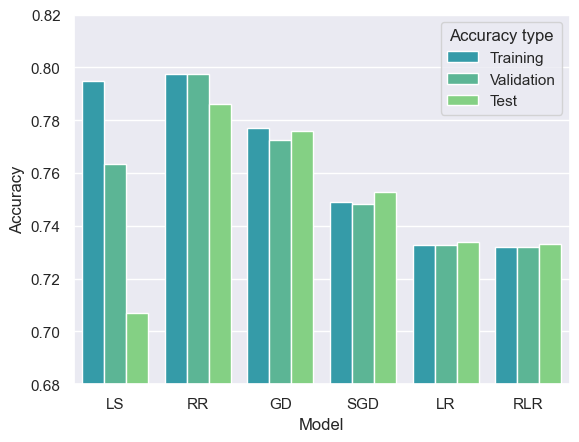

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

accuracy_types = ['Training', 'Validation', 'Test']
model_names = ['LS', 'RR', 'GD', 'SGD', 'LR', 'RLR']
trainAccs = [0.7949, 0.7976, 0.7772, 0.7491, 0.7329, 0.7318]
valAccs = [0.7634, 0.7974, 0.7724, 0.7482, 0.7327, 0.7319]
testAccs = [0.707, 0.786, 0.776, 0.753, 0.734, 0.733]
df = pd.DataFrame(columns=['Model', 'Accuracy type', 'Accuracy'])

for i in range(6):
    df.loc[len(df), df.columns] = model_names[i], 'Training', trainAccs[i]
    df.loc[len(df), df.columns] = model_names[i], 'Validation', valAccs[i]
    df.loc[len(df), df.columns] = model_names[i], 'Test', testAccs[i]
        
sns.set_theme()
g = sns.barplot(x="Model", y='Accuracy', hue="Accuracy type",data=df, palette="blend:#2AB,#7D7")
g.set(ylim=(0.68, 0.82))#, title='Optimal 5-fold cross-validation training and validation accuracies \n and resulting test accuracy of several models on the Higgs Boson dataset')
plt.show()